In [2]:
!pip install ale-py
!pip install gym[atari]
!pip install neat-python
!pip install visualize
!pip install autorom[accept-rom-license]
!pip install gym[atari,accept-rom-license]==0.21.0
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 11.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.2 MB/s eta 0:00:00
  Attempting uninstall: ale-py
    Found existing installation: ale-py 0.8.1
    Uninstalling ale-py-0.8.1:
      Successfully uninstalled ale-py-0.8.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 KB 2.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 KB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for visualize: filename=visualize-0.5.1-py3-none-any.whl size=11479 sha256=f7

Running generation 0

 ****** Running generation 251 ****** 

Population's average fitness: 2.19120 stdev: 1.94010
Best fitness: 8.22000 - size: (5, 33) - species 1 - id 3110
Average adjusted fitness: 0.248
Mean genetic distance 1.291, standard deviation 0.439
Population of 25 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  251    25      8.2    0.248    88
Total extinctions: 0
Generation time: 93.803 sec
Saving checkpoint to neat-checkpoint-251


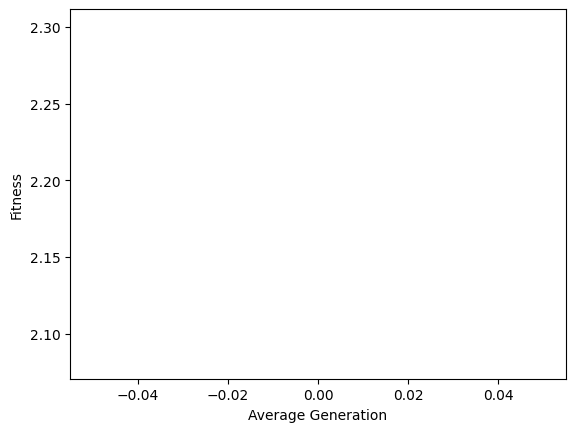

In [9]:
import neat
import visualize
import os
import numpy as np
import gym
from pyvirtualdisplay import Display
#virtual_display = Display(visible=0, size=(1400, 900))
#virtual_display.start()
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
import multiprocessing

def jrender(env, step=None, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode= 'rgb_array'))
    if (step!=None):
        info="step:{}|{}".format(step,info)
    plt.title("%s | %s"%(env.spec.id, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.close()
    

def normalise_ram(ram):
  return ram/255
# Define a function to evaluate the fitness of each genome in a generation


fitness_list = []
def eval_genomes(genomes, config):
    fitnesses = []
    for genome_id, genome in genomes:
        # Create a neural network based on the genome and the given config file
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        # Evaluate the fitness of the genome based on the NN
        genome.fitness = eval_genome(net)
        fitnesses.append(genome.fitness)
    
    avg_fitness = sum(fitnesses) / len(fitnesses)
    fitness_list.append(avg_fitness)

# Define a function to evaluate the fitness of a genome based on the NN
def eval_genome(net):
    total_reward = 0
    for i in range(5):
      env = gym.make('ALE/Breakout-ram-v5')
      env.seed(i)
      obs = env.reset()
      done=False
      episode_reward=0
      
      while not done:
          env.step(1)
          
          # get subset of potentially useful ram to minimise training time
          obs = normalise_ram(obs[[70,71,72,74,80,90,94,95,99,101,103,105,119]])
          # Convert the observation data into a numpy array of floats
          inputs = np.array(obs, dtype=np.float32)
          # Activate the NN based on the observation data
          outputs = net.activate(inputs)
          # Choose an action based on the outputs of the neural network
          action = np.argmax(outputs)
          if action > 0:
            action += 1
          # Take the chosen action in the game environment
          obs, reward, done, info = env.step(action)
          # print(action)
          if obs[72] == 191 or obs[72] == 55:
            illegal_steps += 1
            if illegal_steps == 5:
              episode_reward -= 0.1
          else:
            illegal_steps = 0
          step=+1
          episode_reward += reward
      total_reward += episode_reward
    # Return the total reward earned by the genome as its fitness score
    return total_reward / 5

# Set the path to the configuration file for the NEAT algorithm
config_path = 'config-feedforward.txt'
# Load the configuration file into a NEAT configuration object
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     config_path)
# Create a population of genomes based on the config object
#population = neat.Population(config)
population = neat.Checkpointer().restore_checkpoint("neat-checkpoint-251")
population.add_reporter(neat.StdOutReporter(True))
stats = neat.StatisticsReporter() 
population.add_reporter(stats) 
population.add_reporter(neat.Checkpointer(5))

# Set the number of generations to run

num_generations = 1
fitness_list = []
for i in range(num_generations):
    print("Running generation", i)
    population.run(eval_genomes, 1)
    

plt.plot(range(num_generations), fitness_list)
plt.xlabel('Average Generation')
plt.ylabel('Fitness')
plt.show()



# Get the best genome from the final population
best_genome = population.best_genome
# Create a neural network based on the best genome and the given configuration
best_net = neat.nn.FeedForwardNetwork.create(best_genome, config)


# New section

KeyboardInterrupt: ignored

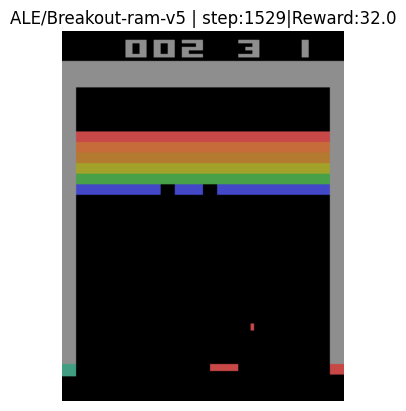

In [11]:
#runs environment like usual with trained NN
env = gym.make('ALE/Breakout-ram-v5')
obs = env.reset()
step = 0
total_reward = 0
while True:
    env.step(1)
    obs = normalise_ram(obs[[70,71,72,74,80,90,94,95,99,101,103,105,119]])
    inputs = np.array(obs, dtype=np.float32)
    outputs = best_net.activate(inputs)
    action = np.argmax(outputs)
    #print(outputs)
    if action > 0:
      action += 1
    #print(action)
    obs, reward, done, info = env.step(action)
    step+=1
    total_reward += reward
    if done:
        obs = env.reset()
    jrender(env,step,"Reward:{}".format(total_reward))